# This notebook is used to develop the SDP version of path planning, different from our previous gradient descent approach on an engineered loss function

Again, we only consider centralized setting. Also, we do not involve the estimation part in the development, assuming the source location is already given.

In [2]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib.lines import Line2D

from IPython.display import HTML

import pickle as pkl
import networkx as nx
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter,joint_meas_func
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import FIM,FIM_mix,analytic_dLdp,analytic_dhdz
from utils.regions import CircleExterior
from tracking_log import logger

 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Import packages.
import cvxpy as cp
from utils.dLdp import dhdr,d2hdr2,analytic_dhdz,analytic_FIM
from utils.DynamicFilters import joint_meas_func

def trust_region_plan_single_step(q,ps,C1s,C0s,ks,bs,bounding_radius = 1):
    '''
    bounding_radius: The physical distance reachable in one time step by the sensors' ability.
    '''
    # Two important helper functions for the trust region
    def trust_region_adjust(prob,step_size,new_p,new_z,new_Fp,p_iter,z_iter,Fp_iter):
        
        
        
        cons = [c.value for c in prob.constraints]
        cons.append(np.all(np.linalg.norm(new_p-ps,axis=1)<=bounding_radius))
        not_violated=np.all(cons)
        
        improved = np.min(np.linalg.eigvals(new_Fp))>np.min(np.linalg.eigvals(Fp_iter))
        
        if (not_violated and improved) or prob.status!='optimal': # To be implemented later
            new_step_size = np.min([step_size*2,bounding_radius])
            return new_p,new_z,new_step_size
        else:
            new_step_size = step_size/2
            return p_iter,z_iter,new_step_size
    
    def solve_linearized_problem(step_size,bounding_radius,p_init,p_iter,z_iter,C1s,C0s,ks,bs):
        # Prepare the raw data
        rs = np.linalg.norm(p_iter-q,axis=1)
        r_hat = ((p_iter-q).T/rs).T
        t_hat=np.zeros(r_hat.shape)
        t_hat[:,0]=-r_hat[:,1]
        t_hat[:,1]=r_hat[:,0]

        d = dhdr(rs,C1s,C0s,ks,bs)
        dd = d2hdr2(rs,C1s,C0s,ks,bs)       

        As = (-d*r_hat.T).T

        Fp=As.T.dot(As) # Current FIM

        # Declare the optimization-related variables.
        dps = cp.Variable(p_iter.shape)
        dz = cp.Variable(nonneg=True)

        # Prepare the matrix directional derivative DF[dps] matrix.
        rhat_conj=[r_hat[i,:,np.newaxis].dot(r_hat[i,np.newaxis,:]) for i in range(len(r_hat))]
        that_conj = [t_hat[i,:,np.newaxis].dot(t_hat[i,np.newaxis,:]) for i in range(len(t_hat))]
        dpdAs =[-dd*rc-1/r*d*tc for dd,d,r,rc,tc in zip(dd,d,rs,rhat_conj,that_conj)]

        dps_As = [dps.T[:,i,np.newaxis]@(As[i,np.newaxis,:]) for i in range(len(As))]

        half_DF = np.hstack(dpdAs)@(cp.vstack(dps_As))

        DF = half_DF+half_DF.T

        # Prepare the objective and constraints
        I = np.eye(p_iter.shape[1])
        constraints = [Fp-z_iter*I+DF-dz*I>>0,
                       cp.norm(p_iter+dps-p_init,axis=1)<=bounding_radius,
                       cp.norm(dps,axis=1)<=step_size]
        prob = cp.Problem(cp.Minimize(-dz),constraints)
        prob.solve()
        if prob.status == 'optimal':
            newFp = analytic_FIM(q,p_iter+dps.value,C1s,C0s,ks,bs)
            return p_iter+dps.value,newFp,z_iter+prob.value,prob
        else:
            return p_iter,newFp,z_iter,prob
           
      
    # The initial z should take value zero.
    z_iter = 0
    # The initial p should take the value of current ps
    p_init = np.array(ps)
    p_iter = np.array(p_init)

    # The initial step size is 0.1
    step_size = 0.1

    # Enter the inner loop of solving a sequence of linearized SDP
    for i in range(100):
        Fp_iter = analytic_FIM(q,p_iter,C1s,C0s,ks,bs)
        
        new_p,new_Fp,new_z,prob = solve_linearized_problem(step_size,bounding_radius,p_init,p_iter,z_iter,C1s,C0s,ks,bs)
        
        p_iter,z_iter,step_size=trust_region_adjust(prob,step_size,new_p,new_z,new_Fp,p_iter,z_iter,Fp_iter) # Adjust the iteration parameters
        
        assert( np.all([c.value for c in prob.constraints]))
        if step_size<1e-4: # Optimality certificate
            break
    return p_iter

In [105]:
def SDP_plan(N_iter):
    src_locs = np.array([[8.,8.]])
    r=0.5
    thetas = np.pi * 2 * np.linspace(0,1,3,endpoint=False)
    sensor_locs = r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+np.array([[0.,0]])


    # Set up mobile sensors and sources
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(sensor_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(sensor_locs,sensor_names)]

    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    std = 0.1


    n_sen = len(mobile_sensors)
    n_src = len(source)
    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)  

    # vs = virtual_sensor(C1,C0,b,k,std)

    # estimator = EKF(q_0,R_mag=0.1,Q_mag=0.1)

    # Set up data logger
    log = logger(sensor_names,src_names)

    ps = np.array([r.loc for r in mobile_sensors])
    qs = np.array([s.loc for s in source])


    h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps)
    dhdz=partial(analytic_dhdz,C1s,C0s,ks,bs)
    f_dLdp = partial(analytic_dLdp,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    # Enter main loop

    for _ in range(N_iter):
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])

    #     y = vs.measurement(qs,ps)
        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)

        

        max_linear_speed = 0.22
        try:
            # Plan
            waypoints = trust_region_plan_single_step(qs,ps,C1s,C0s,ks,bs,bounding_radius = max_linear_speed)
            #Update
            for i in range(n_sen):
                  mobile_sensors[i].update_loc(waypoints[i])

       

        except Exception:
    #         print('Infeasible Solution Encountered')
            # Randomly jitter the sensors.
            for i in range(n_sen):
                p=mobile_sensors[i].loc
                mobile_sensors[i].update_loc(p+np.random.rand(*p.shape)*max_linear_speed)
    #         break



    record=log.export()
    return record

In [103]:
def GD_plan(N_iter):
    src_locs = np.array([[8.,8.]])
    r=0.5
    thetas = np.pi * 2 * np.linspace(0,1,3,endpoint=False)
    sensor_locs = r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+np.array([[0.,0]])



    # Set up mobile sensors and sources
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(sensor_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(sensor_locs,sensor_names)]

    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    std = 0.1


    n_sen = len(mobile_sensors)
    n_src = len(source)
    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)  

    # vs = virtual_sensor(C1,C0,b,k,std)

    # estimator = EKF(q_0,R_mag=0.1,Q_mag=0.1)

    # Set up data logger
    log = logger(sensor_names,src_names)

    ps = np.array([r.loc for r in mobile_sensors])
    qs = np.array([s.loc for s in source])


    h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps)
    dhdz=partial(analytic_dhdz,C1s,C0s,ks,bs)
    f_dLdp = partial(analytic_dLdp,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    # Enter main loop

    for _ in range(N_iter):
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])

    #     y = vs.measurement(qs,ps)
        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)

        # Plan

        max_linear_speed = 0.22
        try:
            planning_timesteps = 1
            planning_dt = 1
            epsilon = 0.5
            hard_boundary = CircleExterior(qs[0],0.5)
            # The FIM waypoint planning  
            waypoints=FIM_ascent_path_planning(f_dLdp,qs[0],ps,n_sen,\
                            planning_timesteps,\
                            max_linear_speed,\
                            planning_dt,\
                            epsilon,hard_boundary)
            for i in range(n_sen):
                  mobile_sensors[i].update_loc(waypoints[0][i])



        except Exception:
    #         print('Infeasible Solution Encountered')
            # Randomly jitter the sensors.
            for i in range(n_sen):
                p=mobile_sensors[i].loc
                mobile_sensors[i].update_loc(p+np.random.rand(*p.shape)*max_linear_speed)
    #         break



    record=log.export()
    return record

# Sensor paths following gradient descent

Computational Time per step(s): 0.0004404973983764648


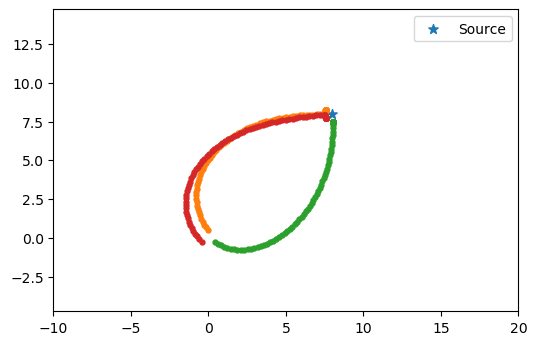

In [106]:
import time
N_iter = 100
t=time.time()
record=GD_plan(N_iter)
print('Computational Time per step(s):',(time.time()-t)/N_iter)

fig, ax = plt.subplots(dpi=100)
ax.cla()
ax.scatter(src_locs[0,0],src_locs[0,1],marker='*',s=50,label='Source')

#     ax.scatter(zhats[:,0],zhats[:,1],marker='*',s=50,label='Estimations',facecolor="None",edgecolor='b')
for sensor, locs in record['sensor_locs'].items():
    ax.scatter(locs[:,0],locs[:,1],marker='.',s=50)
    
ax.axis('on')
ax.axis('equal')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlim((-10,20))
ax.set_ylim((-10,20))
ax.legend()
# ax.set_title()
plt.show()



# Sensor paths following SDP trust-region method(much more computationally expensive than gradient descent)

/home/tianpeng/miniconda3/envs/basics/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computational time per step(s): 0.5442794537544251


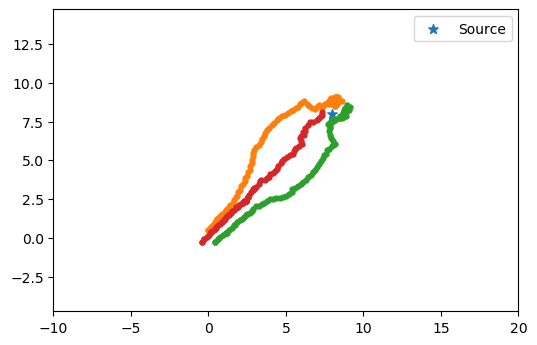

In [107]:
N_iter=100
t=time.time()
record=SDP_plan(N_iter)
print('Computational time per step(s):',(time.time()-t)/N_iter)



fig, ax = plt.subplots(dpi=100)
ax.cla()
ax.scatter(src_locs[0,0],src_locs[0,1],marker='*',s=50,label='Source')

#     ax.scatter(zhats[:,0],zhats[:,1],marker='*',s=50,label='Estimations',facecolor="None",edgecolor='b')
for sensor, locs in record['sensor_locs'].items():
    ax.scatter(locs[:,0],locs[:,1],marker='.',s=50)
    
ax.axis('on')
ax.axis('equal')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlim((-10,20))
ax.set_ylim((-10,20))
ax.legend()
# ax.set_title()
plt.show()



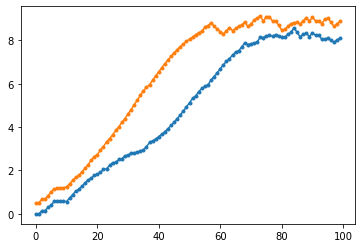

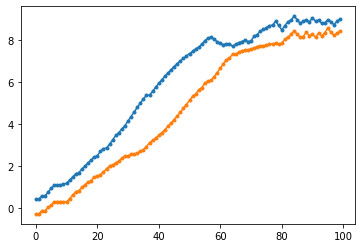

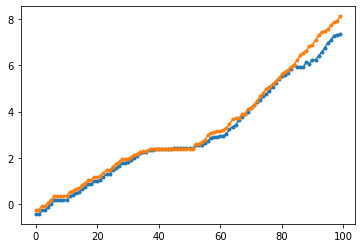

In [108]:
for sensor, locs in record['sensor_locs'].items():
    plt.plot(locs[:,0],marker='.')
    plt.plot(locs[:,1],marker='.')
    plt.show()